# topic-model
SanjayKAroraPhD@gmail.com <br>
December 2018

## Description
This notebook trains topic models on firm pages, segmenting those pages by firm groups as appropriate, and prepares topic modeling outputs at the paragraph level for subsequent Markov modeling

## TODO:
* Consider changing LdaMulticore to Mallet LDA implementation
* Fix lookup to industry and firm size code

In [1]:
%matplotlib inline
import os
import os.path
import random
import re
import gensim
import string
import math
from gensim import corpora
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel
from collections import defaultdict
import copy as cp
from bs4 import BeautifulSoup
from functools import reduce 
import operator
import matplotlib.pyplot as plt
import pprint
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import pprint
import pyLDAvis
import pyLDAvis.gensim

In [2]:
import warnings;
warnings.simplefilter('ignore')

In [3]:
# set this home data dir
BASE_DATA_DIR = "/Users/sarora/dev/EAGER/data/"
# for groups of words not in sentence format, group chunks of content; this is measured in number of characters 
PHRASE_LENGTH = 60

## Load website data from file
Look for text files prepared from MongoDB (the Scrapy scraper)

In [4]:
#import demo text files
in_path = BASE_DATA_DIR + 'orgs/parsed_page_output/' # where in files are stored
out_file = in_path + 'out_topics.csv' # where output files are stored
files = os.listdir(in_path)
files = [item for item in files if item.endswith('.txt')]

In [5]:
#generate pooled text and list of processed documents for topic model
combined_text = []
documents_dict = {}
for i in range(len(files)):
    with open(in_path + files[i], 'r') as my_file:
        text = my_file.readlines() # this is each separate paragraph including headers etc.
        for k in ["\n", "\t", " "]: # remove the end of sentence tags
            text = [item.strip(k) for item in text]
        text = list(filter(lambda x : not x in [' ', '', '\t'],text)) #remove the paragraphs that are just blank space
        documents_dict[files[i]] = text #make a list of lists

## Data Prep

### Prepare text for topic modelling

In [6]:
# run once if needed and download the popular corpora (e.g., stopwords) 
nltk.download(['stopwords', 'punkt'])

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sarora/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/sarora/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [45]:
# pattern regex to remove unwanted words that show up in topic models
p = re.compile(r"(\(\)|''|``|\"|null|ul|li|ol|^\.|^:|^/|\\|--|cooki|'s|corpor|busi|ltd|co\.|compan|keyboard|product|technolog)", flags=re.IGNORECASE)

def encode_item(text):
    '''
    Remove characters with encoding problems 
    '''
    clean = ""
    for item in text.split(" "):
        try:
            clean += item.encode('ascii','ignore').decode('utf-8') + " "
        except: 
            pass
    return clean.rstrip()

stopwords = nltk.corpus.stopwords.words('english') + list(set(string.punctuation))
stemmer = SnowballStemmer("english")

#tokenize text for topic modelling
def stem_tokenizer(text):
    '''
    Tokenize and stem an input sentence"
    '''
    words_stemmed = list(filter(lambda x : not x in stopwords, [stemmer.stem(word) for word in nltk.word_tokenize(text)]))
    return words_stemmed

def clean_text (text):
    clnd_text = list(filter(lambda x : not p.match(x), text))
    return clnd_text

def return_for_model(text):
    '''
    Deal with endcoding and return stemmed/tokenized text
    '''
    all_content = [encode_item(item) for item in text] 
    all_content_stem_token = list(map(stem_tokenizer, all_content))
    all_content_clnd = list(map(clean_text, all_content_stem_token))
        
    return all_content_clnd

In [46]:
# test regex
return_for_model (['this is a technology corporation or company or business or firm that produces products and widgets using tech and productization', 
                   'i am a null sentence with ul li () `` --', 
                  'this has some keyboard-left text and a quotation "safety first"'])

[['firm', 'produc', 'widget', 'use', 'tech'],
 ['sentenc'],
 ['text', 'quotat', 'safeti', 'first']]

In [47]:
def process_doc_list(dict_of_docs):
    '''
    input: lists of documents (which are individually lists of paragraphs)
    output: returns a test/train split of paragraphs and stemmed documents
    '''
    combined_text = []
    documents = []
    dict_of_processed_docs = {}
    print ("Working on " + str(len(dict_of_docs.keys())) + " firm documents")
    c = 1
    for key in dict_of_docs:
        
        document = dict_of_docs[key]
        # print ("Working on doc " + key)
        
        # loop over text and add title elements to the paragraph they describe
        joined = []
        buf = ''
        for i in range(len(document)): # figure out a way to chunk groups of content
            if re.search (r'cookie|privacy|terms|GDPR', document[i], re.IGNORECASE):
                continue
            if len(document[i]) <= 12: # maybe a menu or simple pagragraph heading? 
                continue
            if re.search(r'(\.|;|\!)', document[i]): # found what appears to be a sentence
                if buf:
                    joined.append(buf.strip())
                    buf = ''
                joined.append(document[i].strip())
            elif len(buf) > PHRASE_LENGTH: # the rest of this code processes free-standing text 
                joined.append(buf.strip())
                buf = document[i]
            else: 
                buf = buf + ' ' + document[i]
        if buf:
            joined.append(buf.rstrip())
        
        # pp.pprint (joined)
        
        combined_text += joined # make a big list
        documents.append(joined) # make a list of lists
        # pp.pprint(return_for_model(joined))
        
        dict_of_processed_docs[key] = return_for_model(joined)
    
    combined = return_for_model(combined_text)
    random.shuffle(combined) #randomly shuffle in order to make test train split
    train_index = int(np.round(len(combined)*.8)) #about 80% in the training set
    train = combined[:train_index]
    test = combined[train_index:]
    return train, test, dict_of_processed_docs

### Process Documents for Topic Modelling

In [48]:
# use the preceeding fuction to process the text data
pp = pprint.PrettyPrinter()
all_train, all_test, all_docs_dict = process_doc_list(documents_dict)
# pp.pprint(all_docs_dict)

Working on 956 firm documents


In [35]:
print (len(all_train))
print (len(all_test))
print (len(all_docs_dict.keys()))

65993
16498
956


In [36]:
pp = pprint.PrettyPrinter()
pp.pprint (documents_dict['Ablexis.txt'])
pp.pprint (all_docs_dict['Ablexis.txt'])

['Know How.',
 'Combining decades of experience and deep expertise to create a better '
 'platform for antibody drug discovery.',
 'Ablexis licenses the AlivaMab Mouse, a transgenic mouse that dramatically '
 'improves upon other antibody discovery platforms. A majority of the world’s '
 'top-15 pharmaceutical companies have licensed and use AlivaMab Mouse for '
 'antibody drug discovery at more than a dozen sites around the world.',
 'Founded in 2009, Ablexis brought together decades of knowledge and '
 'experience in building the AlivaMab Mouse, the best-in-class transgenic '
 'platform for generating therapeutic antibody candidates with very high '
 'potency, specificity, solubility and reduced chance of immunogenicity. '
 'AlivaMab Mouse achieves this by incorporating insights and scientific '
 'breakthroughs based on:',
 'An understanding that the choice of platform can impact every step of the '
 'discovery and development processes, with consequences for risks at stages '
 'from

In [37]:
SEGMENT_DIR = BASE_DATA_DIR + "orgs/segments/"

# standard firm cleaning regex
def clean_firm_name (firm):
    firm_clnd = re.sub('(\.|,| corporation| incorporated| llc| inc| international| gmbh| ltd)', '', firm, flags=re.IGNORECASE).rstrip()
    return firm_clnd

def pick_firms (firm_file, all_docs_dict):
    with open(SEGMENT_DIR + firm_file) as f:
        firms = f.readlines()
    clnd_file_names = list(map (lambda x: clean_firm_name(re.sub(r'\/', r'\|', x).rstrip('\r\n')) + '.txt', firms))
    segment_dict = {}
    for name in clnd_file_names:
        if name in all_docs_dict:
            segment_dict[name] = all_docs_dict[name]
        else: 
            pass 
            # print ("Cannot find " + name)
    return segment_dict

In [38]:
# create different training sets by industry
green_firms_file = "green_firms.csv"
synbio_firms_file = "synbio_firms.csv"
nano_firms_file = "nano_firms.csv"

green_docs_dict= pick_firms(green_firms_file, documents_dict)
green_train, green_test, green_docs = process_doc_list(green_docs_dict)

synbio_docs_dict= pick_firms(synbio_firms_file, documents_dict)
synbio_train, synbio_test, synbio_docs = process_doc_list(synbio_docs_dict)

nano_docs_dict= pick_firms(nano_firms_file, documents_dict)
nano_train, nano_test, nano_docs = process_doc_list(nano_docs_dict)

Working on 340 firm documents
Working on 255 firm documents
Working on 557 firm documents


In [39]:
# ...and by size 
small_firms_file = "small_firms.csv"
medium_firms_file = "medium_firms.csv"
large_firms_file = "large_firms.csv"

small_docs_dict= pick_firms(small_firms_file, documents_dict)
small_train, small_test, small_docs = process_doc_list(small_docs_dict)

medium_docs_dict= pick_firms(medium_firms_file, documents_dict)
medium_train, medium_test, medium_docs = process_doc_list(medium_docs_dict)

large_docs_dict= pick_firms(large_firms_file, documents_dict)
large_train, large_test, large_docs = process_doc_list(large_docs_dict)

Working on 462 firm documents
Working on 154 firm documents
Working on 284 firm documents


In [40]:
# train on all docs or a subset
all_train_test = all_train + all_test
synbio_train_test = synbio_train + synbio_test
nano_train_test = nano_train + nano_test 
green_train_test = green_train + green_test

small_train_test = small_train + small_test
medium_train_test = medium_train + medium_test 
large_train_test = large_train + large_test

## Run Topic Modelling

In [18]:
def topic_model(train, test, topics):
    '''
    input: preprocessed test and training data, optionally the number of topics
    output: a fitted LDA topic model and the bow representation of test data for model evaluation
    '''
    random.seed(1)
    #create topic model on full text
    #will need to run on server when we have more data
    full_dict = corpora.Dictionary(train)
    DT_matrix = [full_dict.doc2bow(doc) for doc in train]
    test_token = [full_dict.doc2bow(doc) for doc in test]
    lda = LdaMulticore(DT_matrix, id2word=full_dict, num_topics=topics) 
    return lda, test_token

In [19]:
k = [2, 5, 10, 15, 20, 25, 30, 40 , 50, 75, 100] # possible number of topics
def calculate_perplexities(train,test, k):
    '''
    inputs: preprocessed test and training data, a list of possible number of topics
    outputs: log perplexity and perplexity, scored on the test set
    '''
    log_perplexities = []
    perplexity = []
    for i in k:
        model, test_doc2bow = topic_model(train, test, i)
        log_p = model.log_perplexity(test_doc2bow)
        log_perplexities.append(log_p)
        perp = model.bound(test_doc2bow)
        perplexity.append(perp)
    return log_perplexities, perplexity

In [117]:
all_log_perplexities, all_perplexities = calculate_perplexities(all_train, all_test, k)

In [118]:
green_log_perplexities, green_perplexities = calculate_perplexities(green_train, green_test, k)
synbio_log_perplexities, synbio_perplexities = calculate_perplexities(synbio_train, synbio_test, k)
nano_log_perplexities,nano_perplexities= calculate_perplexities(nano_train, nano_test, k)

In [119]:
small_log_perplexities, small_perplexities = calculate_perplexities(small_train, small_test, k)
medium_log_perplexities, medium_perplexities = calculate_perplexities(medium_train, medium_test, k)
large_log_perplexities,large_perplexities= calculate_perplexities(large_train, large_test, k)

### Perplexity Plots for each website type

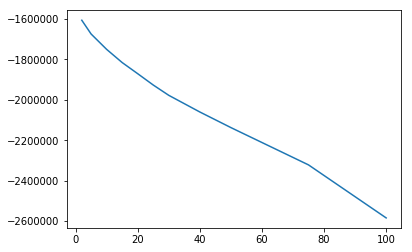

In [120]:
import matplotlib.pyplot as plt
plt.plot(k, all_perplexities)

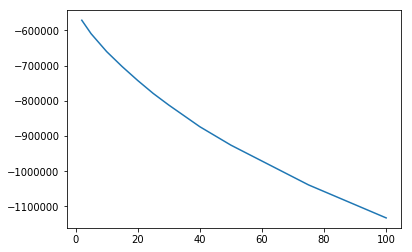

In [121]:
plt.plot(k, green_perplexities)

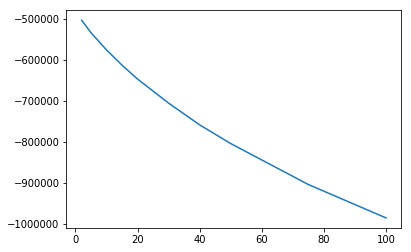

In [122]:
plt.plot(k, synbio_perplexities)

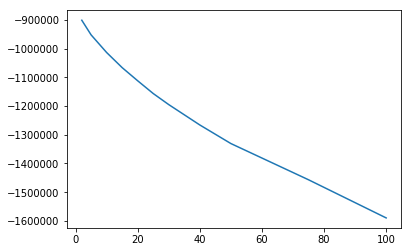

In [123]:
plt.plot(k, nano_perplexities)

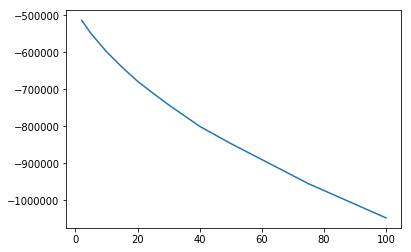

In [124]:
plt.plot(k, small_perplexities)

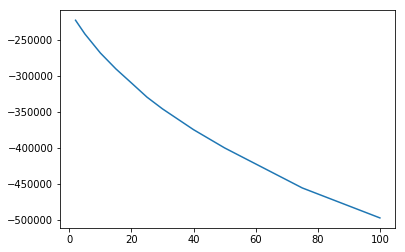

In [125]:
plt.plot(k, medium_perplexities)

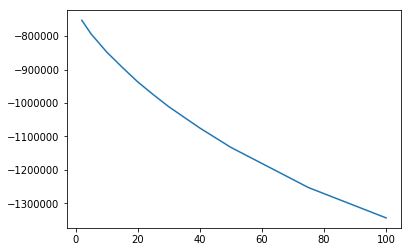

In [126]:
plt.plot(k, large_perplexities)

### Compute coherence scores

In [41]:
# set k boundaries
limit=14; start=4; step=2

# Code from https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/ (#17).
def compute_coherence_values(dictionary, corpus, texts,  start, limit, step):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaMulticore(corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

def visualize_coherence_values (train_test):
    full_dict = corpora.Dictionary(train_test)
    DT_matrix = [full_dict.doc2bow(doc) for doc in train_test]
    
    # Can take a long time to run
    model_list, coherence_values = compute_coherence_values(dictionary=full_dict, corpus=DT_matrix, texts=train_test, start=start, limit=limit,step=step)
    
    # Show graph
    x = list(range(start, limit, step))
    plt.plot(x, coherence_values)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

Working on dataset: all_train_test


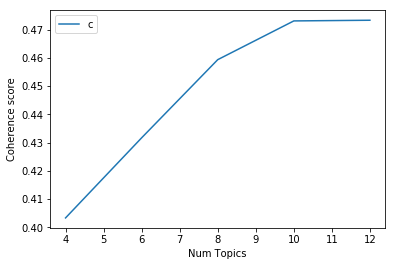

Working on dataset: green_train_test


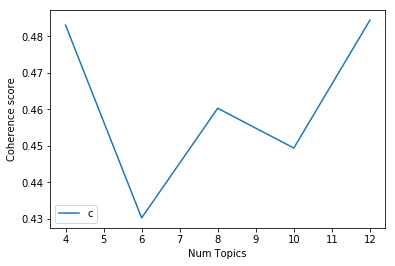

Working on dataset: nano_train_test


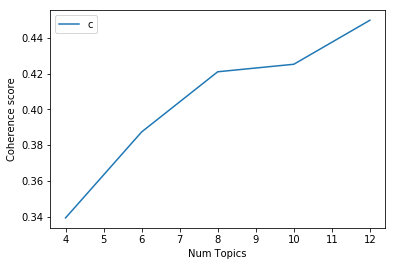

Working on dataset: synbio_train_test


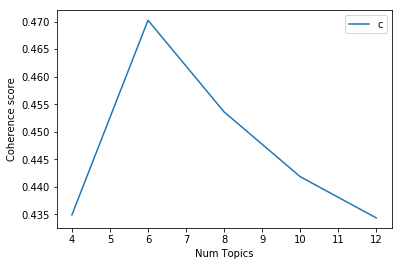

Working on dataset: small_train_test


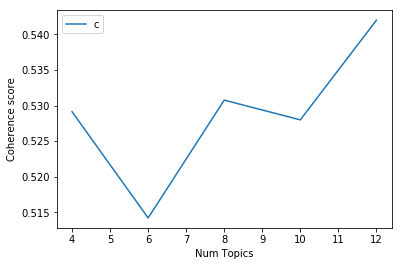

Working on dataset: medium_train_test


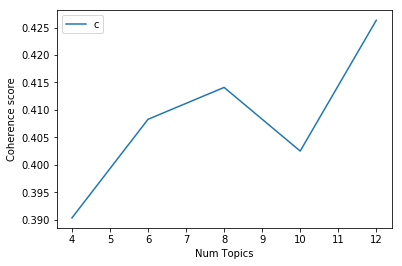

Working on dataset: large_train_test


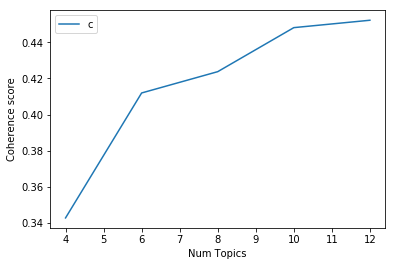

In [42]:
datasets = {'all_train_test': all_train_test, 
            'green_train_test': green_train_test, 'nano_train_test': nano_train_test, 'synbio_train_test': synbio_train_test,
            'small_train_test': small_train_test, 'medium_train_test': medium_train_test, 'large_train_test': large_train_test}
for key, data in datasets.items():
    print ('Working on dataset: ' + key)
    visualize_coherence_values(data)

### Predict topics by paragraph

In [43]:
# define data structs and train model
dataset = datasets['small_train_test']
k = 4

full_dict = corpora.Dictionary(dataset)
DT_matrix = [full_dict.doc2bow(doc) for doc in dataset]
lda = LdaMulticore(DT_matrix, id2word=full_dict, num_topics=k)

#### Visualize topics

In [44]:
LDAvis_prepared = pyLDAvis.gensim.prepare(lda, DT_matrix, full_dict)
pyLDAvis.display(LDAvis_prepared)

In [189]:
x=lda.show_topics(num_topics=k, num_words=10,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]
#Below Code Prints Topics and Words
labels = []
for topic,words in topics_words:
    print(str(topic)+ "::"+ str(words))
    labels.append('|'.join(words[0:3]))

0::['servic', 'system', 'develop', 'energi', 'oper', 'applic', 'global', 'employe', 'manag', 'manufactur']
1::['materi', 'servic', 'inform', 'system', 'offic', 'manag', 'solut', 'innov', 'board', 'industri']
2::['develop', 'industri', 'custom', 'power', 'new', 'servic', 'system', 'us', 'en', 'manag']
3::['manag', 'manufactur', 'power', 'use', 'solar', 'provid', 'cell', 'servic', 'industri', 'ink']
4::['develop', 'bodi', 'servic', 'hover', 'top', 'research', 'use', 'system', 'releas', 'industri']
5::['develop', 'innov', 'manag', 'materi', 'energi', 'state', 'industri', 'power', 'year', 'solut']
6::['materi', 'new', 'develop', 'solut', 'board', 'market', 'custom', 'electron', 'servic', 'inform']
7::['manag', 'develop', 'research', 'industri', 'offic', 'center', 'innov', 'univers', 'energi', 'system']
8::['research', 'use', 'develop', 'inform', 'new', 'provid', 'year', 'work', 'servic', 'system']
9::['develop', 'research', 'global', 'system', 'natur', 'group', 'work', 'network', 'dr.', 'u

In [190]:
# print topic labels for import into R (note these need to be copied into R every time you train a new topic model)
print ("Copy this into R:")
print ('c("' + '", "'.join(labels) + '")')

Copy this into R:
c("servic|system|develop", "materi|servic|inform", "develop|industri|custom", "manag|manufactur|power", "develop|bodi|servic", "develop|innov|manag", "materi|new|develop", "manag|develop|research", "research|use|develop", "develop|research|global", "servic|global|use", "taiyo|ink|servic")


#### Create output data structure and write to file

In [191]:
topic_by_firm_vector = {} # at the firm level

# create output data structure
for firm_key in all_docs_dict:
    firm_paras = all_docs_dict[firm_key]
    main_topic = [] # at the firm level, where each para is an entry
    main_topic_probs = [] # same, but for probabilities
    para_order = []
    para_len = [] 
    order_num = 1
    for para in firm_paras:
        para_len.append(len(para))
        topic_by_prob = sorted([(i[1],i[0]) for i in lda.get_document_topics(full_dict.doc2bow(para))], reverse = True)
        main_topic.append(topic_by_prob[0][1])
        main_topic_probs.append(topic_by_prob[0][0])
        para_order.append(order_num)
        order_num = order_num + 1
    firm_df = pd.DataFrame(
        {'firm': re.sub('\|', '/', firm_key.split('.')[0]), 
         'para_order': para_order,
         'num_words': para_len,
         'main_topic': main_topic,
         'prob': main_topic_probs
        })
    topic_by_firm_vector[firm_key] = firm_df # set at the firm level 

In [192]:
# Test output for a given firm 
print ('Found output for ' + str(len(topic_by_firm_vector.keys())) + ' firms.  Here is an example:')
pp = pprint.PrettyPrinter()
pp.pprint (documents_dict['Ablexis.txt'])
pp.pprint (all_docs_dict['Ablexis.txt'])
print(topic_by_firm_vector['Ablexis.txt'])

Found output for 951 firms.  Here is an example:
['Know How.',
 'Combining decades of experience and deep expertise to create a better '
 'platform for antibody drug discovery.',
 'Ablexis licenses the AlivaMab Mouse, a transgenic mouse that dramatically '
 'improves upon other antibody discovery platforms. A majority of the world’s '
 'top-15 pharmaceutical companies have licensed and use AlivaMab Mouse for '
 'antibody drug discovery at more than a dozen sites around the world.',
 'Founded in 2009, Ablexis brought together decades of knowledge and '
 'experience in building the AlivaMab Mouse, the best-in-class transgenic '
 'platform for generating therapeutic antibody candidates with very high '
 'potency, specificity, solubility and reduced chance of immunogenicity. '
 'AlivaMab Mouse achieves this by incorporating insights and scientific '
 'breakthroughs based on:',
 'An understanding that the choice of platform can impact every step of the '
 'discovery and development processe

In [193]:
# Write to a single output topic file
headers = list(topic_by_firm_vector[list(topic_by_firm_vector.keys())[0]])
if os.path.isfile(out_file):
    os.remove(out_file)
with open(out_file, 'a') as f:
    f.write(','.join(headers) + '\n')
    for firm_key in topic_by_firm_vector:
        df = topic_by_firm_vector[firm_key]
        df.to_csv(f, header=False, index=False)
        
# now go to R